In [1]:
from scipy import sparse
import pandas
import numpy as np
from matplotlib import pyplot as plt
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.tv as tv
import sklearn.preprocessing 

def Ak_from_pairs(k,p):
    Ak = sparse.lil_matrix((int(p*(p-1)/2),p*p))
    ij=0
    for i in range(0,p-1):
        for j in range(i+1,p):
            #print(i*p+k,j*p+k,ij)
            if (i==k)|(j==k):
                Ak[ij,i*p+j]=1
                Ak[ij,j*p+i]=-1
            else:
                Ak[ij,i*p+k]=1
                Ak[ij,j*p+k]=-1
            ij=ij+1
    #return(Ak)
       
    to_keep = list(set(range(Ak.shape[1]))-set(range(0,p*p,p+1)))    
    Aknew = sparse.lil_matrix(sparse.csr_matrix(Ak)[:,to_keep])     
    return(Aknew)




def linear_operator_from_num_variables(num_variables):
    """Generates the linear operator for the TV lasso Nesterov function
    from number of variables.

    Parameters:
    ----------
    num_variables : Integer. The total number of variables, including the
            intercept variable(s).

    """
    A = list()
    for k in range(0,num_variables):
        Ak = Ak_from_pairs(k,num_variables)
        A.append(Ak.tocsr())
    return A

def beta2Beta(beta,p): 
    Beta=np.zeros((p,p))
    for j in range(0,(p-1)):
        for i in range(0,p):
            k=i
            l=j
            if j>=i:
                l=j+1
            Beta[k,l]=beta[i*(p-1)+j]
    return(Beta)  

def precision2regression(K):
    p=K.shape[0]
    M=np.zeros((p,p))
    for i in range(0,p):
        for j in range(0,p):
            if i!=j:
                M[i,j]= - K[i,j]/K[i,i]
    return(M)     


def conesta_rwrapper(X, lam1, lam2):
    X=np.array(X)
    n=X.shape[0]
    p=X.shape[1]
  
    X=sklearn.preprocessing.scale(X)
    y=X.reshape(n*p,1,order='F')
    Xvec=np.delete(np.kron(np.identity(p),X),range(0,p*p,p+1),axis=1)
    A=linear_operator_from_num_variables(p)
  
    l = lam1  # l1 lasso coefficient
    k = 0.0  # l2 ridge regression coefficient
    g = lam2 
  
    hgmm = estimators.LinearRegressionL1L2TV(l, k, g, A, mu=0.001,
                                           algorithm=algorithms.proximal.CONESTA(max_iter=1000), mean=False)
    res = hgmm.fit(Xvec,y)
    Beta=beta2Beta(res.beta,p)
    #print(res.score(Xvec, y))
  
    return(Beta)


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\pylearn_parsimony-0.3.1-py3.7.egg\parsimony\config.py:55: RuntimeWarning: Could not locate the config file.


In [2]:
# minus and plus lines with reodering the coefficients

def minus_lines(i, j, Beta, ni = 1, nj = 1):
    Y_coeffs = Beta[i, :].copy()
    X_coeffs = Beta[j, :].copy()
    X_i = X_coeffs[i]
    X_coeffs[i] = X_coeffs[j]
    X_coeffs[j] = X_i
    return ni*Y_coeffs - nj*X_coeffs

def plus_lines(i, j, Beta, ni = 1, nj = 1):
    Y_coeffs = Beta[i, :].copy()
    X_coeffs = Beta[j, :].copy()
    X_i = X_coeffs[i]
    X_coeffs[i] = X_coeffs[j]
    X_coeffs[j] = X_i
    return ni*Y_coeffs + nj*X_coeffs

In [3]:
# Cost function

def cost(Beta, X, lambda1=0, lambda2=0):
    p = X.shape[1]
    P2 = 0
    L = 0
    # loss term
    if (p > 1):
        L = np.sum(np.vectorize(lambda i: np.linalg.norm(X[:,i] - X @ Beta[i,:])**2)(range(p)))

        # fuse-group lasso penalty
        for i in range(p-1):
            for j in range(i+1,p):
                P2 = P2 + np.linalg.norm(minus_lines(i, j, Beta))

    # lasso penalty
    P1 = np.sum(np.abs(Beta))
    
    return L + lambda1*P1 + lambda2*P2

In [4]:
# distances Beta
def dist_beta(Beta, distance = "euclidean"):
    K = Beta.shape[1]
    
    if (K != 1):
        diffs = np.ones((K, K))*np.inf
        for i in range(K-1):
            for j in range(i+1,K):
                diffs[i,j] = np.linalg.norm(minus_lines(i, j, Beta))
    
        if (distance == "relative"):
            Dsum = np.ones((K, K))
            for i in range(K-1):
                for j in range(i+1,K):
                    Dsum[i,j] = np.linalg.norm(Beta[i,:]) + np.linalg.norm(Beta[j,:])

            diffs = diffs/Dsum

    else:
        diffs = np.zeros((1,1))
  
    return diffs

In [5]:
# Merge X
def mergeX(X, pair_to_merge, clusters):
    X = X.copy()
    i = np.min(pair_to_merge)
    j = np.max(pair_to_merge)
  
    ni = np.sum(clusters == i)
    nj = np.sum(clusters == j)
  
    X[:,i] = (ni*X[:,i] + nj*X[:,j])/(ni + nj)
    X = np.delete(X, j, 1)
    
    return X

#' Merge Beta
#' Different types of merging and their effect
def merge_beta(Beta, pair_to_merge, clusters):
    Beta = Beta.copy()
    i = min(pair_to_merge)
    j = max(pair_to_merge)
  
    ni = np.sum(clusters == i)
    nj = np.sum(clusters == j)
  
    Beta[i,:] = plus_lines(i, j, Beta, ni, nj) / (ni + nj)
    Beta = np.delete(np.delete(Beta, j, 1), j, 0)
  
    return Beta

#' Merge labels
def merge_labels(merged_pair, labels):
    i = min(merged_pair)
    j = max(merged_pair)
    labels[i] = max(labels)+1
    labels = np.delete(labels, j , None)
    return labels

#' Merge counts
def merge_counts(merged_pair, counts):
    i = min(merged_pair)
    j = max(merged_pair)
    counts[i] = counts[i]+counts[j]
    counts = np.delete(counts, j , None)
    return counts

In [21]:
def merge_proc(pairs_to_merge, 
               clusters, 
               X,
               Beta,
               level,
               gain_level,
               gains,
               labels,
               merge,
               counts,
               size):
    X = X.copy()
    Beta = Beta.copy()
    for l in range(pairs_to_merge.shape[0]):
        pair_to_merge = pairs_to_merge[l,:]
    
        # can also take the 1st element cause it's always the min for a upper-triangular matrix
        i = np.min(pair_to_merge)
        j = np.max(pair_to_merge)
    
        if(i != j):
            
            # update size of clusters
            size[level] = counts[i] + counts[j]
            counts = merge_counts(pair_to_merge, counts)
      
            # merge lines/cols in Beta and X
            Beta = merge_beta(Beta, pair_to_merge, clusters)
            X = mergeX(X, pair_to_merge, clusters)
      
            # update dendrogram
            merge[level, :] = [labels[i], labels[j]]
            labels = merge_labels(pair_to_merge, labels)
            gains[level] = 0 if l>0 else np.nan
      
            # merge clusters
            clusters[clusters == j] = i 
            clusters[clusters > j] = clusters[clusters > j] - 1
      
            # update the rest of the table with the new clusters
            pairs_to_merge[pairs_to_merge == j] = i
            pairs_to_merge[pairs_to_merge > j] = pairs_to_merge[pairs_to_merge > j] - 1
            
            level = level + 1
            
    out_mergeproc = {"clusters" : clusters, 
                     "Beta" : Beta, 
                     "X" : X, 
                     "level" : level, 
                     "gains" : gains, 
                     "merge" : merge, 
                     "labels" : labels,
                     "counts" : counts,
                     "size" : size}
    return(out_mergeproc)


In [52]:
def hggm2(X, 
          lambda1=0, 
          fuse_thresh = 1e-3, 
          maxit = 1000, 
          silent = True, 
          distance = "euclidean", 
          solver = "conesta", 
          lambda2_start = 1e-4, 
          lambda2_factor = 1.5):
    ## Initialisations
    X = X.copy()
    X = np.array(X)
    p = X.shape[1]
    gains = np.zeros(p-1)
    merge = np.zeros((p-1, 2)) # matrix of merging clusters at each level
    old_level = level = 0
    labels = np.arange(p)   # vector of clusters labels
    clusters = np.arange(p)
    counts = np.ones(p)
    height = np.zeros(p-1)
    size = np.zeros(p-1)
    
    lambda2 = lambda2_start
    old_lambda2 = 0
    old_lambda1 = lambda1
    Beta = conesta_rwrapper(X, lambda1, old_lambda2)
  
    old_costf = costf =  cost(Beta, X, lambda1, old_lambda2)
  
    t = 0 # index for the out list.
    iteration = 0
    out = []
    out = np.append(out, {"Beta" : Beta, "clusters" : clusters.copy()})
    #names(out)[[1]] = "level0"
    prev = len(np.unique(clusters))
    ## End Initialisations
  
  
    ## Loop until all the variables merged
    while (len(np.unique(clusters)) > 1):
        oldp = X.shape[1]
        #iteration = iteration + 1
    
        Beta = conesta_rwrapper(X, lambda1, lambda2)
    
        ## Update distance matrix
        diffs = dist_beta(Beta, distance = distance)
    
        ## Clustering starts here
        pairs_to_merge = np.concatenate(np.where(diffs<=fuse_thresh)).reshape((2,-1)).T
    
        if (pairs_to_merge.shape[0] != 0):
            
            gain_level = costf - old_costf
            out_mergeproc = merge_proc(pairs_to_merge, clusters, X, Beta, level, gain_level, gains, labels, merge, counts, size)

            X        = out_mergeproc['X']
            Beta     = out_mergeproc['Beta']
            clusters = out_mergeproc['clusters']

            level    = out_mergeproc['level']
            gains    = out_mergeproc['gains']
            merge    = out_mergeproc['merge']
            labels   = out_mergeproc['labels'] 
            counts   = out_mergeproc['counts']
            size   = out_mergeproc['size']
            height[old_level:level] = lambda2
            
            old_level = level
        ## Clustering ends here
    
        costf = cost(Beta, X, lambda1, lambda2)
        #cat("nclusters =", length(unique(clusters)), "lambda2", lambda2, "cost =", costf, "\n")
        print("nclusters: ", len(np.unique(clusters)), "lambda2 :", lambda2, "cost: ", costf)
        
        gains[np.isnan(gains)] = old_costf - costf
        old_costf = costf
    
        if(len(np.unique(clusters)) != prev):
            out = np.append(out, {"Beta" : Beta, "clusters" : clusters.copy()})
            #names(out)[[t]] <- paste0("level", (p-length(unique(clusters))))
            prev = len(np.unique(clusters))
            t = t + 1
    
        old_lambda2 = lambda2
    
        lambda2 = lambda2*lambda2_factor
        
    tree = np.c_[merge, height, size, np.cumsum(gains)]
  
    result = {"out" : out, "tree" : tree}
  
    return(result) 

In [49]:
X = pandas.read_csv("toy_example.csv")
#X = pandas.read_csv("test.txt", delimiter=" ")

In [56]:
m = hggm2(X)

nclusters:  5 lambda2 : 0.0001 cost:  185.96724513553656
nclusters:  5 lambda2 : 0.00015000000000000001 cost:  185.96737113227164
nclusters:  5 lambda2 : 0.00022500000000000002 cost:  185.9675601229289
nclusters:  5 lambda2 : 0.0003375 cost:  185.96784360998404
nclusters:  5 lambda2 : 0.00050625 cost:  185.96826883913897
nclusters:  5 lambda2 : 0.000759375 cost:  185.96890667442347
nclusters:  5 lambda2 : 0.0011390624999999999 cost:  185.9698634178201
nclusters:  5 lambda2 : 0.0017085937499999998 cost:  185.97129850633507
nclusters:  5 lambda2 : 0.0025628906249999996 cost:  185.97345107994195
nclusters:  5 lambda2 : 0.0038443359374999994 cost:  185.9766798015642
nclusters:  5 lambda2 : 0.00576650390625 cost:  185.981522583319
nclusters:  5 lambda2 : 0.008649755859375 cost:  185.98878606631493
nclusters:  5 lambda2 : 0.0129746337890625 cost:  185.99967971237885
nclusters:  5 lambda2 : 0.01946195068359375 cost:  186.01601655464717
nclusters:  5 lambda2 : 0.029192926025390625 cost:  186.0

In [57]:
m['tree']

array([[  0.        ,   1.        ,   5.68151287,   2.        ,
        143.30346274],
       [  5.        ,   2.        ,   5.68151287,   3.        ,
        143.30346274],
       [  6.        ,   3.        ,   5.68151287,   4.        ,
        143.30346274],
       [  7.        ,   4.        ,   8.5222693 ,   5.        ,
        192.91009305]])

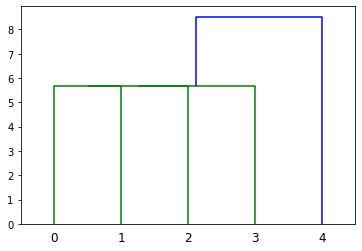

In [68]:
# by lambda2
from scipy.cluster import hierarchy
dn = hierarchy.dendrogram(m['tree'][:,[0,1,2,3]])
plt.show()

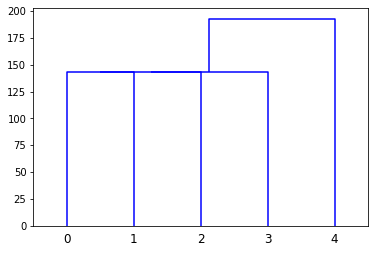

In [67]:
# by gains
dn = hierarchy.dendrogram(m['tree'][:,[0,1,4,3]])
plt.show()